# Lesson 3: Learning from data

Let us first download the required python packages:

In [1]:
import numpy as np # numpy comes from "numeric python" and it is a very popular library for numerical operations
import pandas as pd # pandas provides more advanced data structures and methods for manipulating data
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt # a widely used visualiation library
import cartopy.crs as ccrs # a geographic stuffwhich we use for plotting
import cartopy
import json
import os
import requests # for querying the data from internet
import io # for io operations
import urllib # for building the query string
import urllib.parse # --||--
import seaborn as sns

import plotting_utils # A self made "plotting library" to hide the less important parts of code

import sklearn #               sklearn is a good library for doing basic machine learning, 
import sklearn.preprocessing # in addition to that, it contains some neat preprocessing stuff
import sklearn.linear_model
import sklearn.ensemble
import sklearn.cluster
import sklearn.datasets
import sklearn.decomposition

import pickle # for storing files and variables

And then the preprocessed data for regression and classification tasks:

In [2]:
with open('datasets/water_quality.pkl', 'rb') as handle:
    data_dict_water_quality = pickle.load(handle)
data_dict_water_quality['features'] = ['LATITUDE', 'LONGITUDE', 'OBSDEP', 'YEAR', 'SINMONTHFRACTION', 
                                       'COSMONTHFRACTION', 'SINTIMEOFDAYFRACTION', 'COSTIMEOFDAYFRACTION']
data_dict_water_quality['target'] = 'TEMP' 

data_dict_water_quality_classification = data_dict_water_quality.copy()
data_dict_water_quality_classification['target'] = 'TOTOXYLOW'


/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Supervised learning

There is a multitude of ML methods for both classification and regression tasks. In this course, we present a few central, widely used methods.

### Linear regression

Linear regression is familiar to many of us from basic statistics classes. It strives to find the best linear model to explain the numerical value of the target variable based on the values of the explaining variable(s). Linear regression tells us how strong is the (linear) relationship between the variables. The linear model simply searches for an equation

y = a + b * x 

in which the y values predicted by this equation are as close as possible to the true values in the data. What is "as close as possible" is usually evaluated through *mean squared error* (see chapter on performance metrics). 

<img src="img/linear_regression.png"/>
Linear regression from the iris data set (Figure: LU).

Linear regression can have as many explanatory factors as desired. In that case, the equation becomes

$y = a + b_1 * x_1 + b_2 * x_2 + ... + b_n * x_n$

(The regular linear model assumes that the explaining factors are independent of each other, for exapmle that the effect of sunny days on a plant's growth is the same regardless of soil's moisture content, or vice versa. However it may be true that sun and moisture together boost the plant growth more than the sum of the effect of each of them alone. Linear models can be extended to take into account the potential interaction between explaining variables.)

### How to do it in practice

##### First we unpack the data from the dictionaries

In [3]:
# Unpack the variables from the dictionaries
data_frame_numeric = data_dict_water_quality['data_frame_numeric']
normalizer = data_dict_water_quality['normalizer']
features_normalizer = data_dict_water_quality['normalized_columns']
features_regression = data_dict_water_quality['features']
feature_target = data_dict_water_quality['target']

data_frame_normalized = data_frame_numeric.copy()
data_frame_normalized[features_normalizer] = normalizer.transform(data_frame_numeric[features_normalizer])

# Put the data to matrices to be understandable by the algorithms:
X = data_frame_normalized[features_regression].values
y = data_frame_normalized[[feature_target]].values.reshape((-1,1))

#### Then we split the data to train and validation data at random (See lecture 2 for details)

Please note that linear regression model is so simple that there is no true risk of overfitting and we don't use test data

In [4]:
indices = np.random.permutation(X.shape[0])
train_indices = indices[:int(X.shape[0]*0.8)]
validation_indices = indices[int(X.shape[0]*0.8):]
X_train, y_train = X[train_indices,:], y[train_indices,:]
X_validation, y_validation = X[validation_indices,:], y[validation_indices,:]

#### Then we fit the linear regression model to the training data

As mentioned in the text this finds the coefficients so that the predicitons are "as close as possible" to the actual measurements. In below, the model uses "mean squared error" (see details at the end of the lecture)

In [5]:
reg = sklearn.linear_model.LinearRegression().fit(X_train, y_train)

# Predict the outcomes for the validation data
y_pred = reg.predict(X_validation).reshape(-1)

# Print the coefficients of each feature; they tell the importance of that feture for the purpose of prediction
print(features_regression)
print(reg.coef_)

# Print the goodness of the fit (score) of the model fit  
print(reg.score(X_validation, y_validation))

['LATITUDE', 'LONGITUDE', 'OBSDEP', 'YEAR', 'SINMONTHFRACTION', 'COSMONTHFRACTION', 'SINTIMEOFDAYFRACTION', 'COSTIMEOFDAYFRACTION']
[[-9.23670373e-02  2.50918219e-02 -2.78659117e-01 -7.34541955e-04
   1.01767842e+00 -1.21314194e+00 -4.25940108e-02 -3.54577066e-02]]
0.7784229546240894


It seems that Observation depth and time of year affect most to the results as their coefficients have largest absolute values

#### We then visualize the predictions on the validation data in comparison to the actual measurements to see where the model fails

/tmp/ipykernel_2779/3566581525.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_['res'] = y_pred - y_validation.reshape(-1)


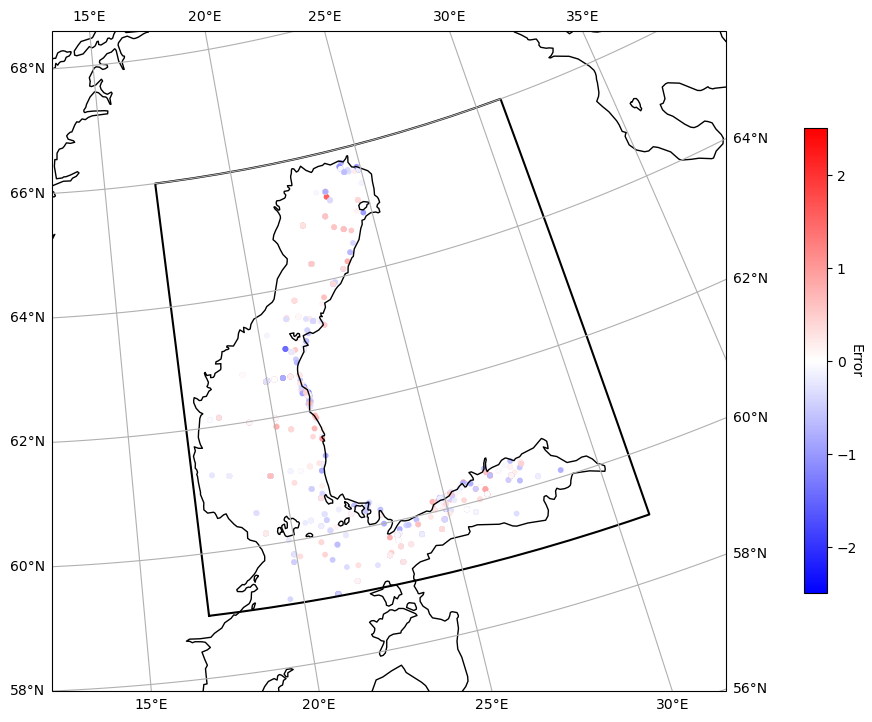

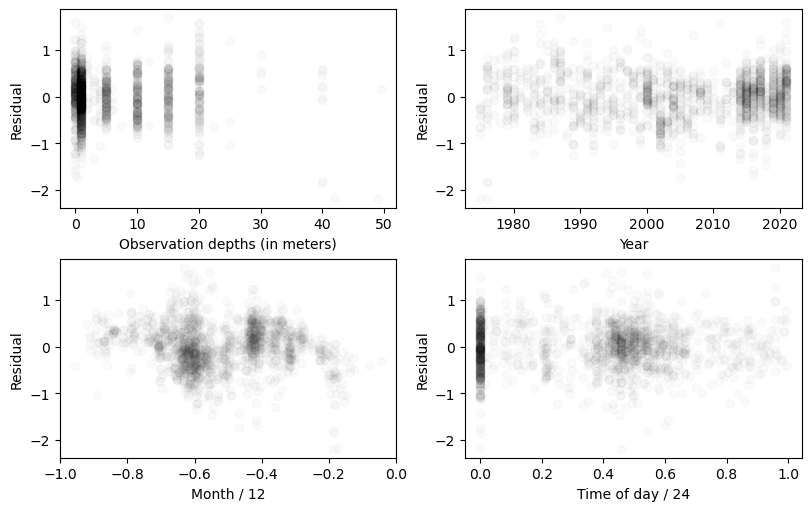

In [6]:
bounding_box = [17.0, 59.0, 31.0, 66.0] # From Lesson-1
plotting_utils.scatterplot_in_map(data_frame_numeric.iloc[validation_indices]['LONGITUDE'], 
                                  data_frame_numeric.iloc[validation_indices]['LATITUDE'], 
                                  bounding_box=bounding_box, 
                                  bounding_box_context=plotting_utils.BOUNDS_NORTHERN_BALTIC_SEA,
                                  c=y_pred-y_validation.reshape(-1),cmap='bwr', s=10, 
                                  vmin=-2.5, vmax=2.5, stock_img=False)
cbar = plt.colorbar(fraction=0.03, pad=0.1)
cbar.set_label('Error', rotation=270)


data_ = data_frame_numeric.iloc[validation_indices]
data_['res'] = y_pred - y_validation.reshape(-1)
plotting_utils.plot_scatter(data_,
                            columns_x=[('OBSDEP', "Observation depths (in meters)"),
                                       ('YEAR', "Year"),
                                       ('MONTHFRACTION', "Month / 12"),
                                       ('TIMEOFDAYFRACTION', "Time of day / 24")], 
                            columns_y=[('res','Residual')], 
                            c='k', alpha=0.02, ncols=2)

This naive visualization shows that the model is able to make rather unbiased marginal estimates. This means that the predictions deviate around zero for all variables. However, there are few exceptions: 
* The biggest prediction mistakes happen far away from coast (The colors are more saturated far from the coast)
* The model systematically predicts too low temperatures for early months

Nothing too surprising here. **If we would see something unexpected here (e.g. biases), we should reason why it happens**

#### Finally we visualize the predictive behaviour of the model by setting the data to its median and making predictions with respect to one feature at a time

/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.w

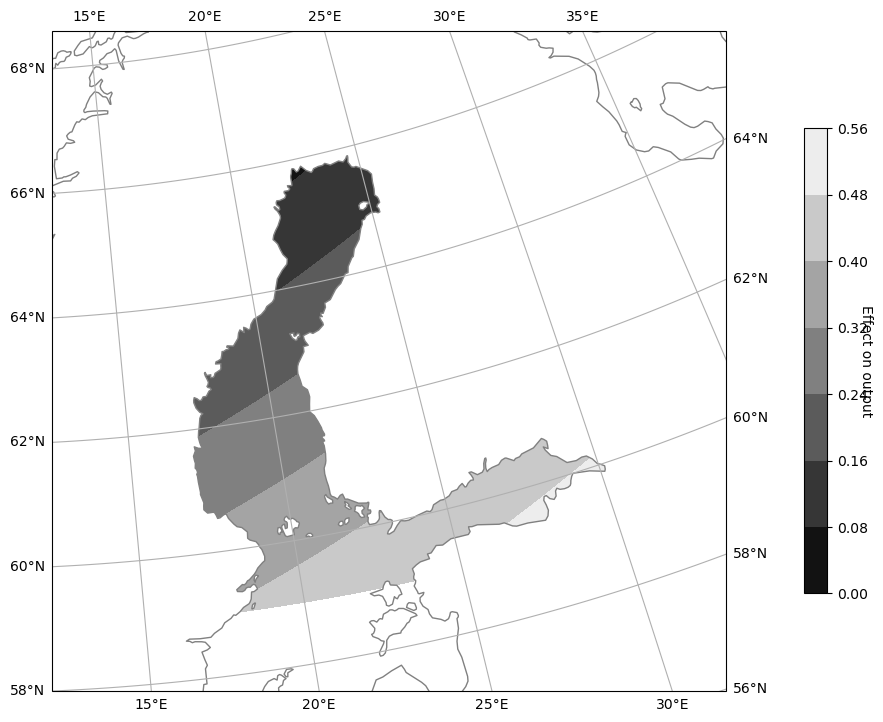

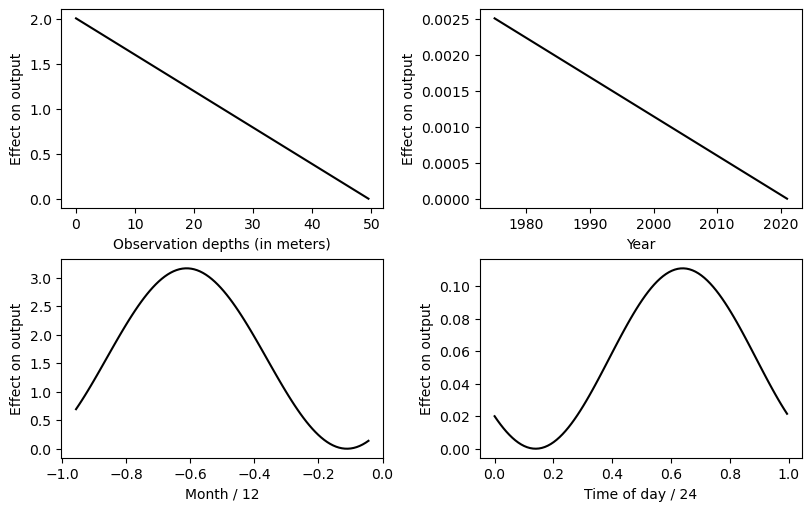

In [7]:
plotting_utils.plot_effects(data_frame_numeric.iloc[validation_indices], 
                            reg, features_regression,
                            normalizer, features_normalizer, 
                            plotted_columns=[('OBSDEP', "Observation depths (in meters)"),
                                             ('YEAR', "Year"),
                                             ('MONTHFRACTION', "Month / 12"),
                                             ('TIMEOFDAYFRACTION', "Time of day / 24")],
                            periodic_columns=['MONTHFRACTION', 'TIMEOFDAYFRACTION'], ncols=2,
                            coordinates=['LATITUDE', 'LONGITUDE'], bounding_box=bounding_box)

The results show the same as the coefficients: Observation depth and month have the biggest effect. Nothing surprising here. **If we would see something unexpected here, we should reason why it happens**

### Logistic regression

Logistic regression (also called logit model) is, despite the name, a classification method for binary variables based on continuous explaining variables. The concept of logistic regression is illustrated in the figure below. In the figure, x axis shows how many hours the students have studied for their exam, and the y axis has two possible values, pass and fail. We want to predict, based on the study hours, whether the student is going to pass the exam or not. The logistic curve assumes that the likelihood for pasing the exam increases with the study time, but the increase may not be linear but sigmoid-shaped function. For binary prediction (pass or fail) we can take the ponit where the curve crosses the halfway point between pass and fail, and see how many hours of study does this correspond to (in this case, something like 2 hours and 45 minutes). Below this value, we predict fail, and above it, pass.

<img src="img/Exam_pass_logistic_curve.jpeg" width="600" />
Image from Wikipedia, by Michaelg2015 - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=42442194

### How to do it in practice

##### First we unpack the data from the dictionaries

In [8]:
# Unpack the variables from the dictionaries
data_frame_classification_numeric = data_dict_water_quality_classification['data_frame_numeric']
classification_normalizer = data_dict_water_quality_classification['normalizer']
features_classification_normalizer = data_dict_water_quality_classification['normalized_columns']
features_classification = data_dict_water_quality_classification['features']
feature_classification_target = data_dict_water_quality_classification['target']

data_frame_classification_normalized = data_frame_classification_numeric.copy()
data_frame_classification_normalized[features_classification_normalizer] = classification_normalizer.transform(data_frame_classification_numeric[features_classification_normalizer])

# Put the data to matrices to be understandable by the algorithms:
X = data_frame_classification_normalized[features_classification].values
y = data_frame_classification_normalized[[feature_classification_target]].values.reshape((-1,1))

#### Then we split the data to train and validation data at random (See lecture 2 for details)

Please note that logistic regression model is so simple that there is no true risk of overfitting and we don't use test data

In [9]:
np.random.seed(0)
indices = np.random.permutation(X.shape[0])
train_indices = indices[:int(X.shape[0]*0.8)]
validation_indices = indices[int(X.shape[0]*0.8):]
X_train, y_train = X[train_indices,:], y[train_indices,:].reshape(-1)
X_validation, y_validation = X[validation_indices,:], y[validation_indices,:].reshape(-1)

#### Then we fit the logistic regression model to the training data

As mentioned in the text this finds the coefficients so that the predicitons are "as close as possible" to the actual measurements. In below, the model uses "mean squared error" (see details at Lesson-4). This is encoded as 'l2'-loss to the model. We will get back to different losses at Lesson-4 so don't pay attention to understanding this now

Score (accuracy) for the validation set: 0.8307086614173228


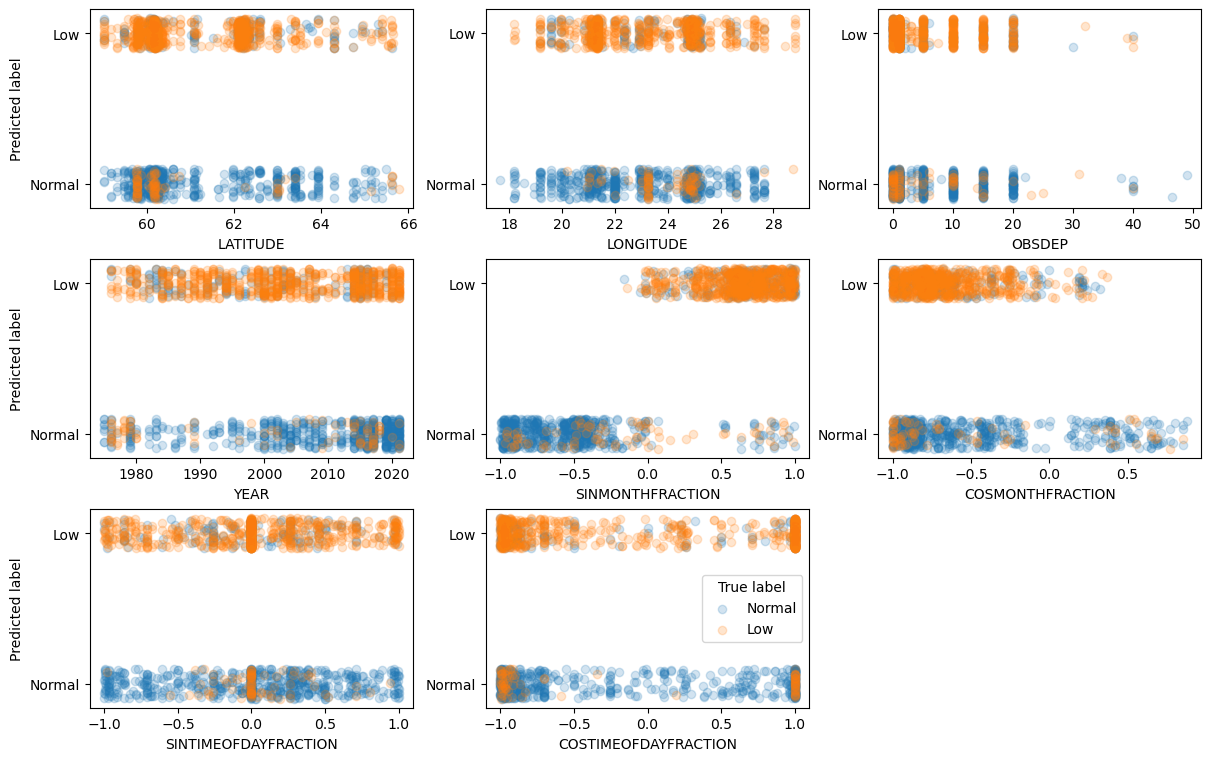

In [10]:
penalty='l2'
clf = sklearn.linear_model.LogisticRegression(penalty=penalty).fit(X_train, y_train)

print("Score (accuracy) for the validation set:", clf.score(X_validation, y_validation))

y_pred = clf.predict(X_validation)
data_ = data_frame_classification_numeric.iloc[validation_indices]
plotting_utils.plot_residuals_classification(data_[features_classification], 
                                             y_pred, y_validation.reshape(-1), 
                                             label_names=[(0, "Normal"), (1, "Low")], alpha=0.2)

There seems to be no apparent biases and the prediction performance is OK! Plainly put: just using linear regression and a threshold to decide the class, we can achieve 79.9% accuracy. BUT hold your horses! We made one very risky decision

#### We then visualize the predictions on the validation data in comparison to the actual measurements to see where the model fails
We will cover the methods shown here (Confusion matrix and ROC-curve) on Lesson-4! No need to pay attention now, but remember, you should come back here during Lesson-4

/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


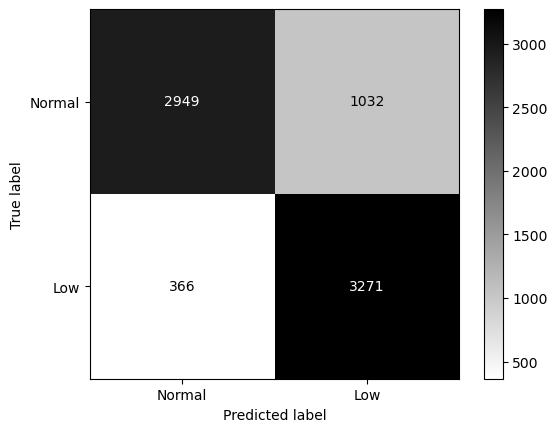

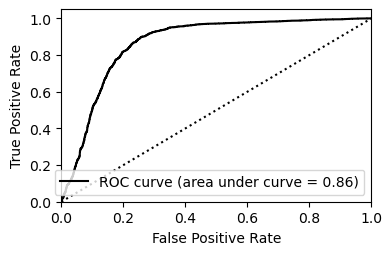

In [11]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(clf, data_frame_classification_normalized[features_classification], 
                                      data_frame_classification_normalized[feature_classification_target].values.reshape(-1), 
                                      display_labels=['Normal','Low'], cmap='binary')


y_test = data_frame_classification_normalized[data_dict_water_quality_classification['target']]
lr_probs = clf.predict_proba(data_frame_classification_normalized[features_classification])
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

#print(y_score)
plotting_utils.draw_binary_roc(y_test.values, lr_probs)


Nothing too surprising here. **If we would see something unexpected here (e.g. biases), we should reason why it happens**

#### Finally we visualize the predictive behaviour of the model by setting the data to its median and making predictions with respect to one feature at a time

/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  

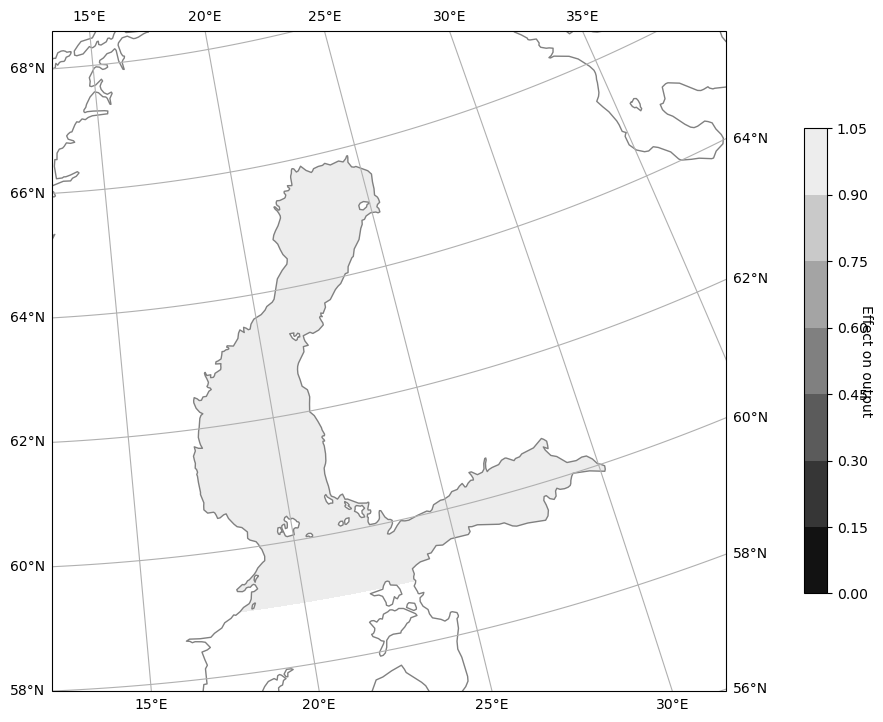

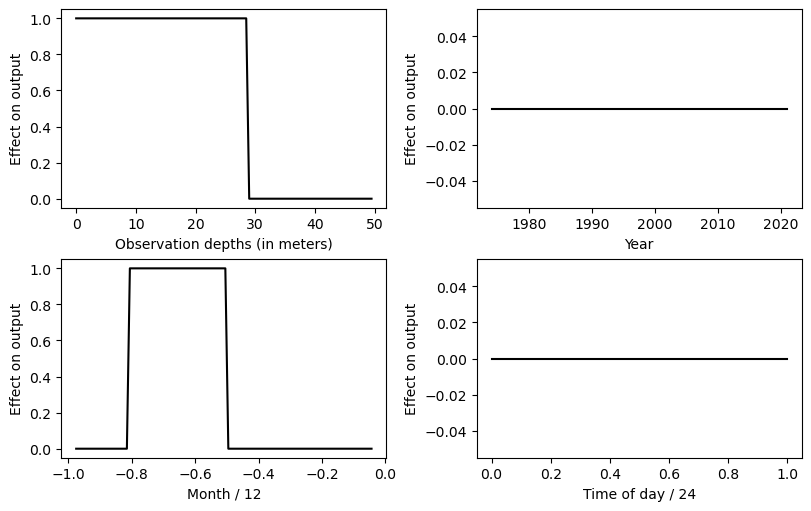

In [12]:
plotting_utils.plot_effects(data_frame_classification_numeric, clf,
                            features_classification, classification_normalizer, features_classification_normalizer,
                            plotted_columns=[('OBSDEP', "Observation depths (in meters)"),
                                             ('YEAR', "Year"),
                                             ('MONTHFRACTION', "Month / 12"),
                                             ('TIMEOFDAYFRACTION', "Time of day / 24")],
                            periodic_columns=['MONTHFRACTION', 'TIMEOFDAYFRACTION'], ncols=2,
                            coordinates=['LATITUDE', 'LONGITUDE'], bounding_box=bounding_box)

OK, not very useful to be honest! It would probably be more insightful to do the visualization by assuming an interesting location (latitude and longitude) and seeing how the prediction changes if e.g.  changes? Maybe you can even change the visualization script to do this (if you want)?

### Support vector machine

Support vector machines (SVM) are popular and robust binary classifiers (although multiclass and regression extensions exist). The basic idea is to separate the two classes as well as possible using a line (or in multidimensional cases, a plane/hyperplane that separates the two classes. In the image below, H1, the green line does not separate the two classes. Lines H2 (blue) and H3 (red) do, H3 so with the biggest margin.

<img src="img/SVM.svg" width="500"/>
Figure from Wikipedia, by User:ZackWeinberg, based on PNG version by User:Cyc - This file was derived from:  Svm separating hyperplanes.png, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=22877598

The line with the biggest margin is very sensitive to individual observations: adding just one observation might move the line considerably, as illustrated in the figure below: the right hand side plot has one additional blue dot, which shifts the maximal margin line considerably.

<img src="img/Support_vector_ISLR95.png" width="800"/>
Figure source: James et al. Introduction to statistical Learning. Springer. Doi:10.1007/978-1-4614-7138-7.

Also naturally, it is not always possible to find a line/plane that separates the classes perfectly. SVM fitting tries to find a separating line (often called *decision boundary*, as it is the boundary at which the decision about which class to redict changes) that is somewhat robust to individual observations, and does not overfit to the training set. This may mean that some of the training data observations are misclassified (on the wring side of the line), and others lie very close to the decision boundary. SVM fitting includes a parameter that can be understood as the width of the margin around the decision boundary, and it regulates the robustness of the model fit. A large margin means many observations lie within the margins, meaning that there are many support vectors, i.e. many observations determining the decision boundary. A smaller margin means that there are fewer support vectors and the model react more strongly to the features of the training set, posibly overfitting to it. The figure below illustrates the different margins on a small data set.

<img src="img/Support_vector_ISLR97.png" width="700" />
Figure source: James et al. Introduction to statistical Learning. Springer. Doi:10.1007/978-1-4614-7138-7.


An interesting feature of the SVMs is that only the observations that either lie on the margin or on the wrong side of the decision boundary affect it. Changing an observation that is correctly classified and not on the margin will not affect the model fit at all. The observations that do affect the result, i.e. those that are on the margin or on the wrong sice of the classifier, are called *support vectors*. Intuitively, it can be thought that the decision boundary "leans" on these observations. 

Sometimes the decision boundary is not a straight line, but a curve or circle. SVMs can be adapted to deal with these kind of data as well through the use of *kernels*. The details of kernels are too technical to discuss here, but essentially they make transformations to the data that allow us to fit polynomial and radial (round) separating lines. The figure below illustrates this with a radial kernel: adding an extra dimension (z-axis, "up") and mapping the points so that te further they are from the centre of the original 2-dimendional space, the higher up they are on the z axis, allows the separation of the two classes using a straight plane.

<img src="img/Kernel_trick_idea.svg" width="800"/>
Figure source: By Shiyu Ji - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=60458994


Further reading:
- [A nice, longer explanation of SVMs.](https://towardsdatascience.com/support-vector-machine-simply-explained-fee28eba5496)
- [Another nice explanation of SVMs, including support vetor regression.](https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/)

### How to do it in practice

We don't need to unpack the data as we already did it for the logistic regression task

#### Then we fit the SVM model to the training data

SVM model is also very simple, so there is no risk of overfitting; no need to use spearate test data

Score (accuracy) for the validation set: 0.8622047244094488


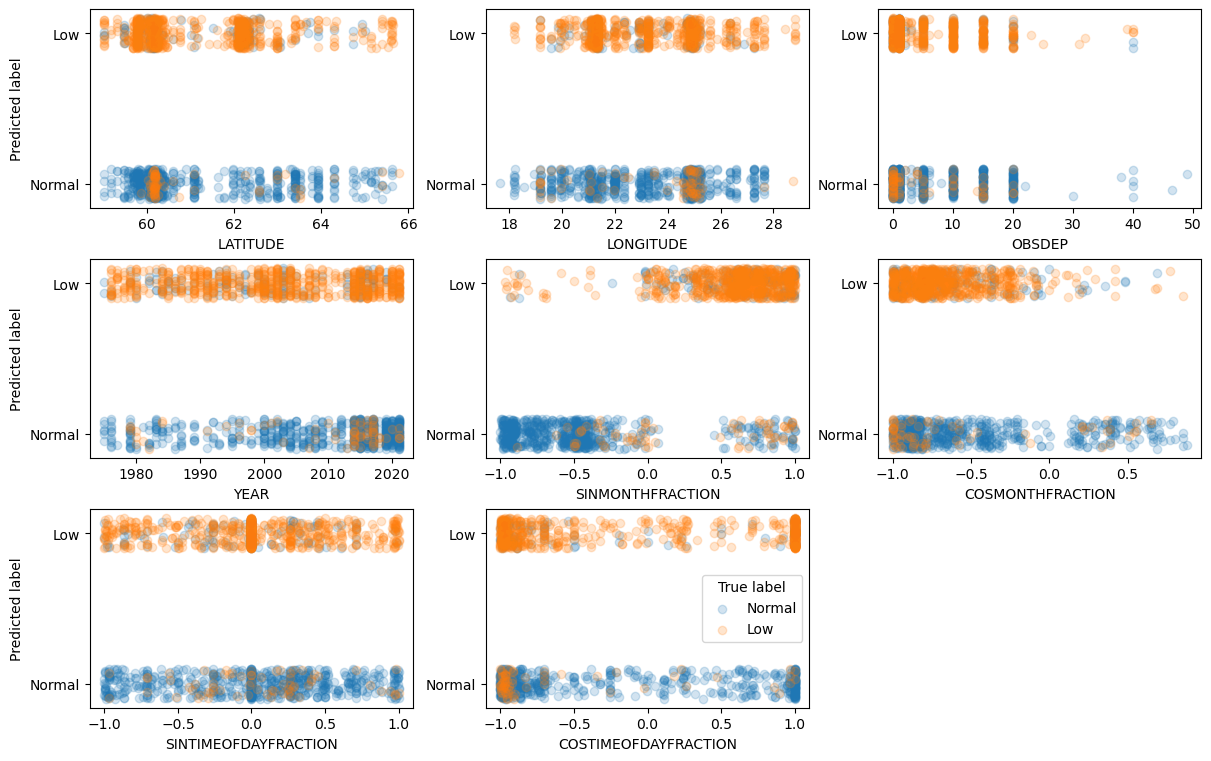

In [13]:
kernel = 'rbf' # options: 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed', default is ’rbf’
clf = sklearn.svm.SVC(kernel=kernel, probability=True).fit(X_train, y_train)

print("Score (accuracy) for the validation set:", clf.score(X_validation, y_validation))

y_pred = clf.predict(X_validation)
data_ = data_frame_classification_numeric.iloc[validation_indices]
plotting_utils.plot_residuals_classification(data_[features_classification], 
                                             y_pred, y_validation.reshape(-1), 
                                             label_names=[(0,"Normal"), (1,"Low")], alpha=0.2)

There seems to be no apparent biases available and the performance is not much better than for the logistic regression. **Complexity does not always mean better performance and linear models are often good enough**. The complexity increases risk of overfitting and this is exactly what happens now.

#### We then visualize the predictions on the validation data in comparison to the actual measurements to see where the model fails

/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


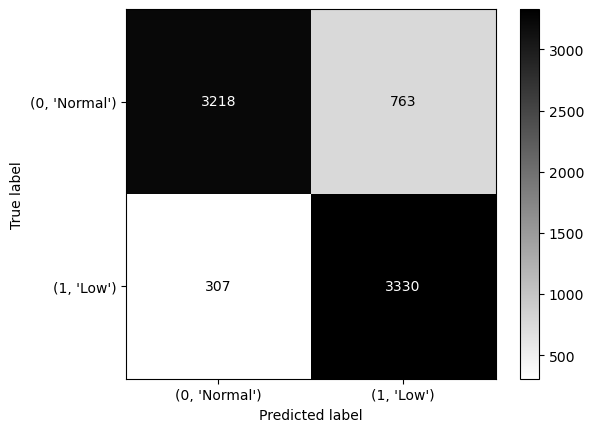

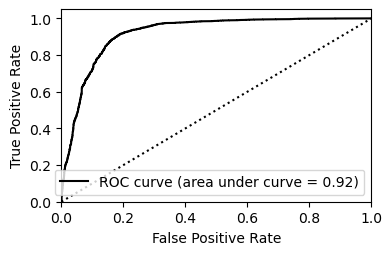

In [14]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(clf, data_frame_classification_normalized[features_classification], 
                                      data_frame_classification_normalized[feature_classification_target], 
                                      display_labels=[(0,'Normal'),(1,'Low')], cmap='binary')


y_test = data_frame_classification_normalized[feature_classification_target]
#y_score = clf.decision_function(data_frame_ckd_normalized[classification_columns])
lr_probs = clf.predict_proba(data_frame_classification_normalized[features_classification])
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

#print(y_score)
plotting_utils.draw_binary_roc(y_test.values, lr_probs)

Nothing too surprising here.

#### Finally we visualize the predictive behaviour of the model by setting the data to its median and making predictions with respect to one feature at a time

/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


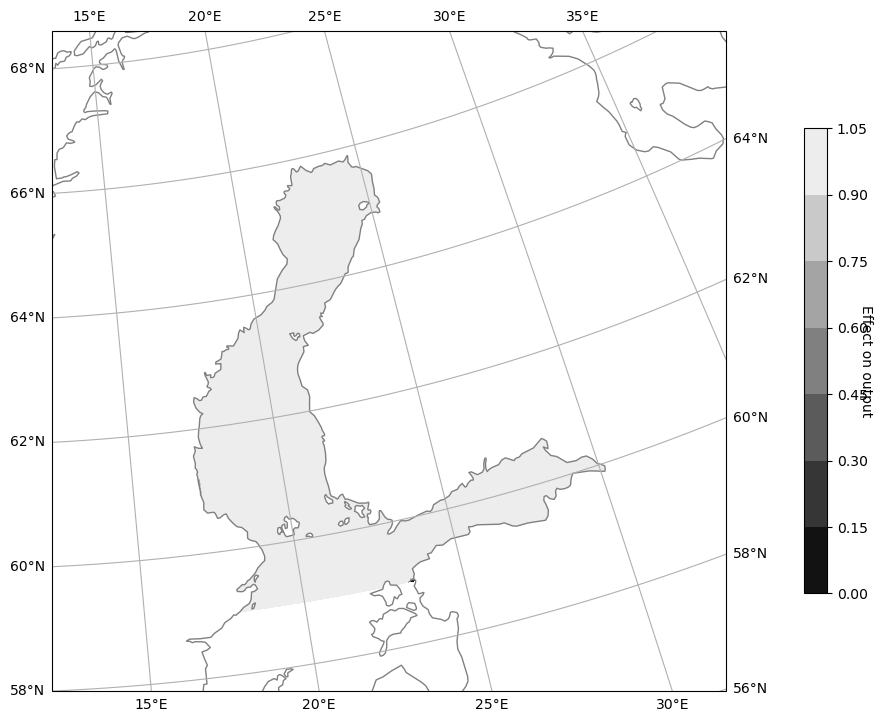

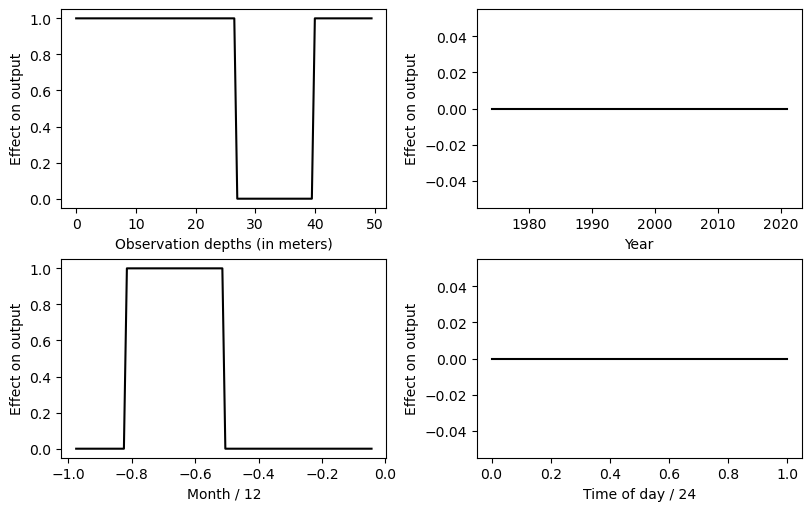

In [15]:
plotting_utils.plot_effects(data_frame_classification_numeric, clf,
                            features_classification, classification_normalizer, features_classification_normalizer,
                            plotted_columns=[('OBSDEP', "Observation depths (in meters)"),
                                             ('YEAR', "Year"),
                                             ('MONTHFRACTION', "Month / 12"),
                                             ('TIMEOFDAYFRACTION', "Time of day / 24")],
                            periodic_columns=['MONTHFRACTION', 'TIMEOFDAYFRACTION'], ncols=2,
                            coordinates=['LATITUDE', 'LONGITUDE'], bounding_box=bounding_box)

### Tree-based methods: basics and random forest classification and regression

Decision trees are based on the idea of consecutively splitting the data (*prediction space*) into regions that are more uniform than the whole data or the previous split. Splitting is continued until the predictions don't improve. This splitting can be presented as a tree, hence the name. The figure below illustrates this concept. 

<img src="img/decision_tree.png">
Figure: LU.

In this figure, we are predicting the class (shape) based on the *mode* i.e. most common class in each region. This is classification. If the target variable was numeric, we could predict a numeric value by taking the average of all observations in the region. This would be regression.

Trees are easy to interpret, but not competitive with the best machine learning  methods. There performance of tree.based methods can be improved through using a consensus result of multiple trees through methods such as *bagging, boosting,* and *random forests*. We will take a look at random forests, as they are a commonly used, powerful method for classification and regression.

**Random forest**

Random forest uses multiple trees (hence *forest*) to create a classifier / regression model that is more robust to the variance in the training set than individual trees are. They use two tricks for this: 
- *Bagging* i.e. *bootstrapping*, that is, taking repeated samples from the training set to produce multiple training sets. The model is taught using each of these bootstrapperd trainingsets separately, and finally, an average of these predictions is used as the final model.
- Using only a random subset (hence *random*) of the predictor variables at each split. The size of this subset is usually close to the sciare root of the number of predictor variables.

Bagging improves the robustness of the method, i.e. different training sets result in more similar models than without bagging.Selecnig only a subset of the predictors for each split further improves the robustness, and also helps when there is a large number of correlated predictors in the data.

The average (when predicting numeric value) or majority (when predicting class) prediction of all the trees will be used as the prediction of the random forest model.

There is a nice added bonus to bagging: we get model validation for free as a side effect. Each bootstrapped tree uses on average 2/3 of the observations. The remaining 1/3 are called *out-of-bag (OOB)* observations. We can validate the model by using these OOB observations, predicting each observation using the trees that have not used this particular observation in learning. With a large number of bootstrapped samples, this OOB validation is as good as leave-one-out cross-validation.

[A longer explanation of random forest.](https://towardsdatascience.com/random-forest-explained-6b4849d56a2f)

### How to do it in practice

##### First we unpack the data from the dictionaries

In [16]:
# Unpack the variables from the dictionaries
data_frame_numeric = data_dict_water_quality['data_frame_numeric']
normalizer = data_dict_water_quality['normalizer']
features_normalizer = data_dict_water_quality['normalized_columns']
features_regression = data_dict_water_quality['features']
feature_target = data_dict_water_quality['target']

data_frame_normalized = data_frame_numeric.copy()
data_frame_normalized[features_normalizer] = normalizer.transform(data_frame_numeric[features_normalizer])

# Put the data to matrices to be understandable by the algorithms:
X = data_frame_normalized[features_regression].values
y = data_frame_normalized[[feature_target]].values.reshape((-1,1))

#### Then we split the data to train and validation data at random (See lecture 2 for details)

Please note that logistic regression model is so simple that there is no true risk of overfitting and we don't use test data

In [17]:
indices = np.random.permutation(X.shape[0])
train_indices = indices[:int(X.shape[0]*0.8)]
validation_indices = indices[int(X.shape[0]*0.8):]
X_train, y_train = X[train_indices,:], y[train_indices,:]
X_validation, y_validation = X[validation_indices,:], y[validation_indices,:]

#### Then we fit the logistic regression model to the training data

As mentioned in the text this finds the coefficients so that the predicitons are "as close as possible" to the actual measurements. In below, the model uses "mean squared error" (see details at the end of the lecture). This is encoded as 'l2'-loss to the model.

In [18]:
reg = sklearn.ensemble.RandomForestRegressor(n_estimators=1000, max_depth=8, min_samples_split=6, min_samples_leaf=3, bootstrap=True)
reg.fit(X_train, y_train.reshape(-1))

# Predict the outcomes for the validation data
y_pred = reg.predict(X_validation).reshape(-1)

# Print the goodness of the fit (score) of the model fit  
print(reg.score(X_validation, y_validation))

0.8784187218674042


There seems to be no apparent biases available

#### We then visualize the predictions on the validation data in comparison to the actual measurements to see where the model fails

/tmp/ipykernel_2779/1609515839.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_['res'] = y_pred - y_validation.reshape(-1)


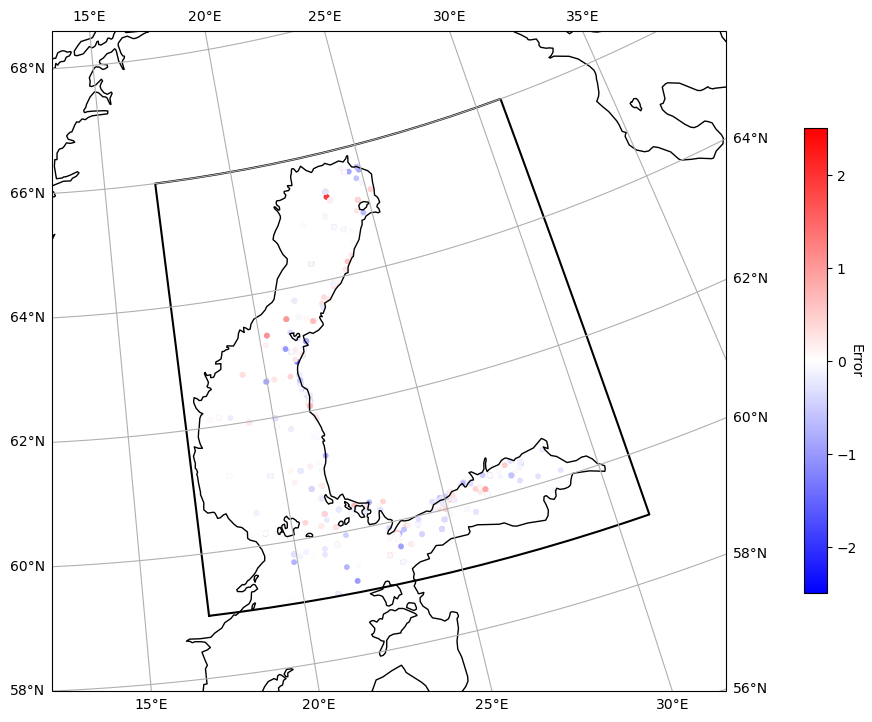

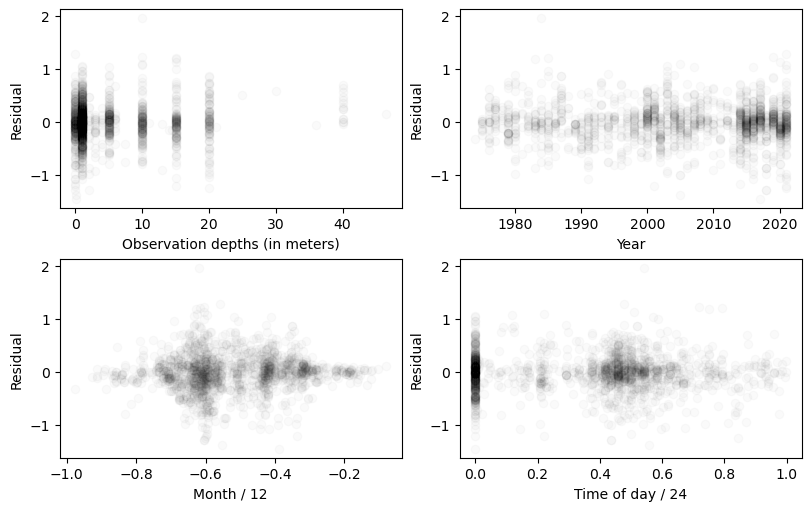

In [19]:
bounding_box = [17.0, 59.0, 31.0, 66.0] # From Lesson-1
plotting_utils.scatterplot_in_map(data_frame_numeric.iloc[validation_indices]['LONGITUDE'], data_frame_numeric.iloc[validation_indices]['LATITUDE'], bounding_box=bounding_box, 
                                  bounding_box_context=plotting_utils.BOUNDS_NORTHERN_BALTIC_SEA,c=y_pred-y_validation.reshape(-1),cmap='bwr', s=10, vmin=-2.5, vmax=2.5, stock_img=False)
cbar = plt.colorbar(fraction=0.03, pad=0.1)
cbar.set_label('Error', rotation=270)


data_ = data_frame_numeric.iloc[validation_indices]
data_['res'] = y_pred - y_validation.reshape(-1)
plotting_utils.plot_scatter(data_, columns_x=[('OBSDEP', "Observation depths (in meters)"),
                                             ('YEAR', "Year"),
                                             ('MONTHFRACTION', "Month / 12"),
                                             ('TIMEOFDAYFRACTION', "Time of day / 24")], 
                            columns_y=[('res','Residual')], c='k', alpha=0.02, ncols=2)

Nothing too surprising here. **If we would see something unexpected here (e.g. biases), we should reason why it happens**

#### Finally we visualize the predictive behaviour of the model by setting the data to its median and making predictions with respect to one feature at a time

/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/esiivola/miniconda3/envs/syke-ml-course/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without f

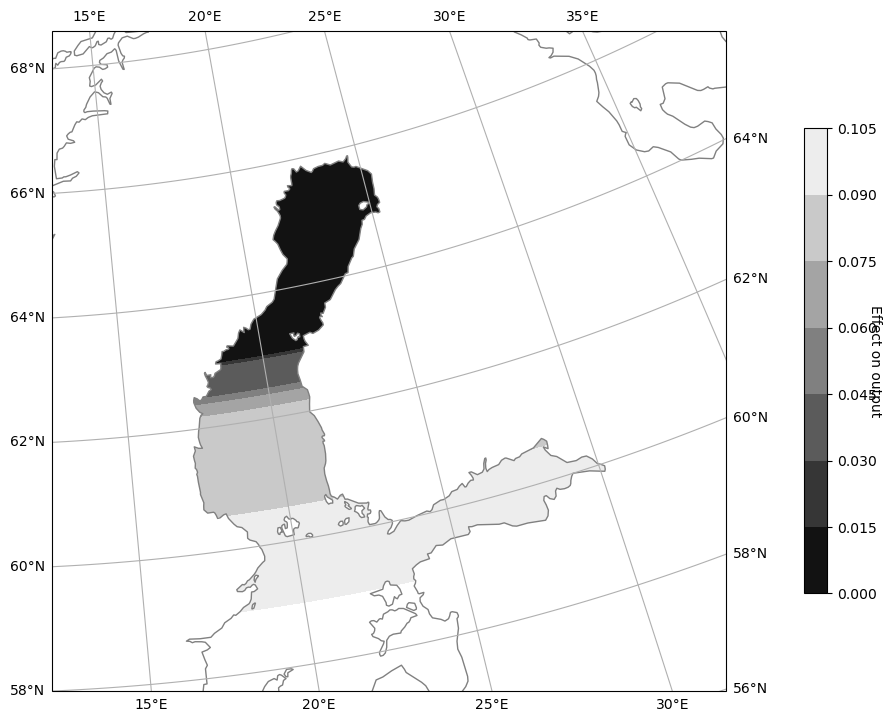

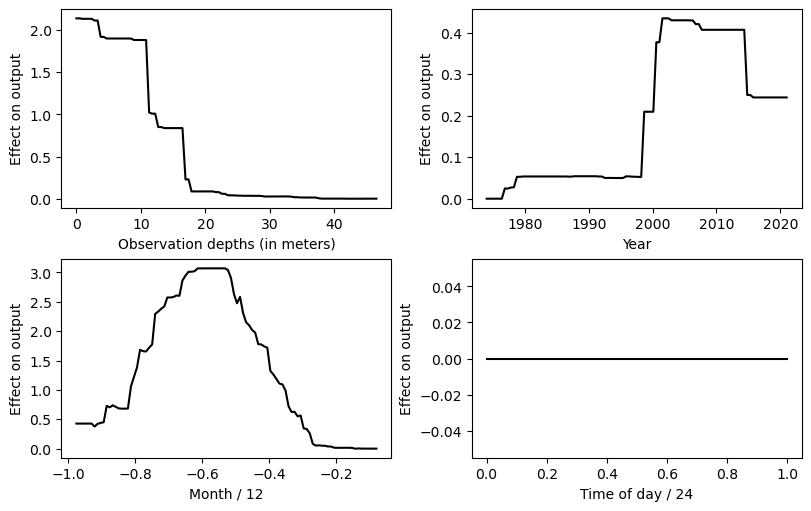

In [20]:
plotting_utils.plot_effects(data_frame_numeric.iloc[validation_indices], 
                            reg, features_regression,
                            normalizer, features_normalizer, 
                            plotted_columns=[('OBSDEP', "Observation depths (in meters)"),
                                             ('YEAR', "Year"),
                                             ('MONTHFRACTION', "Month / 12"),
                                             ('TIMEOFDAYFRACTION', "Time of day / 24")],
                            periodic_columns=['MONTHFRACTION', 'TIMEOFDAYFRACTION'], ncols=2,
                            coordinates=['LATITUDE', 'LONGITUDE'], bounding_box=bounding_box)

### K nearest neighbours

K nearest neighbors (KNN) a classification and regression method. In classification, the object is classified as the same class as majority of the k closest training examples in data set, in regression, the predicted value is the average of the values of k nearest neighbors. The predictors can also be weighted according to their distance from the point that is being predicted.

## Time for you to do practice:
Perform regression with the ice thickness data you downloaded before. Performs regression and visualize and analyze the results. Use linear regression and/or SVM and/or random forests. If you use multiple methods, compare the results :)

In [21]:
#Insert your code here

#This block fails if the tasks in the previous lectures are not done
#with open('datasets/ice_thickness.pkl', 'rb') as handle:
#    data_dict_ice_thickness = pickle.load(handle)
#data_dict_ice_thickness['features'] = ['LATITUDE', 'LONGITUDE', 'YEAR', 'SINMONTHFRACTION',
#                                       'COSMONTHFRACTION', 'SINTIMEOFDAYFRACTION', 'COSTIMEOFDAYFRACTION']
#data_dict_ice_thickness['target'] = 'THICKNESS' 

## Extra material: Unsupervised learning: Clustering, association and dimensionality reduction

Unsupervised methods are often used as part of exploratory data analysis, to reveal patterns in the data. As we don't know the true answer, there is also no way to check how well the algorithm is doing. That makes unsupervised methods difficult to evaluate. However, they may be important in exploring and understanding the data.


### Clustering

Clustering means grouping observations into groups that have similarity with each other - for example, finding species that seem to share features such as habitat or food preferences, body morphology, etc. Finding clusters can be intuitively thought of as identifying "groups" of observations, i.e. observations that are "close" to each other in the feature space, i.e. as measured by the variables that have been recorded, form a cluster. This naturally requires some way to meaasure the distance, or (dis)similarity between the objects. For this purpose, it might be reasonable to normalize the data so that all numeric variables have the same mean and variance - that way, all the variables will have equal weight in the distance measuring. If the variables are not normalized and one variable had the scale from 0-1000 meters and another 0-0.1 meters, the differences in the first variable would dominate the distance metric and the second variable would be virtually meaningless. There is a high number of different distance measures. The Euclidean distance is perhaps the most common. You can read more about distance measures [here](https://machinelearningmastery.com/distance-measures-for-machine-learning/).

There are many different types of clustering algorithms. [Watch this 9-minute video](https://www.youtube.com/watch?v=Se28XHI2_xE), which gives a very nice illustration of 4 different types of clustering algorithms. 

**Partitioning clustering** (or centroid clustering) divides the data to k clusters, where k is provided by the user. (There are also ways to evaluate what the optimal k would be.) **K means** clustering is perhaps the most common of these. It starts from k random observations and iteratively calculates clusters ,trying to minimize the variation within clusters. As the starting ponist are random, and they affect the algorithm's results, several runs are needed and the best one is picked. 
[This YouTube video illustrates k-means clustering.](https://www.youtube.com/watch?v=4b5d3muPQmA).

**Hierarchical clustering** (or connectivity clustering) shows the similarity or distance between any two observations. Methos start either from individual observations, connecting the closesto observations of identified gropus to each other sequentially, until all observations are connected, or starting from a group of all observations and splitting the group consecutively until each observation is in its own group.

### Association 

Association rule finding means finding relations between variables in data sets. This means, for example, finding that lakes that have a high abundance of roach also tend to have a high abundance of sander, while lakes that have vendace also tend to have whitefish. These rules can also be more complex, such as that if a forest has a high percentage of aspen trees, and the average age of trees is above 30 years, it is likelier to host flying squirrels than other forests.


### Dimensionality reduction

Dimensionality reduction means the transformation of the high-dimensional data set (i.e. one with many variables) into fewer dimensionswhile retaining as much of its meaninful properties as possible. It can be done through *feature selection*, i.e. leaving out variables, or *feature extraction*, i.e. constructing new variables based on the original ones so that fewer new variables replace the original ones and include most of their information content. Principal component analysis is an example of the latter.


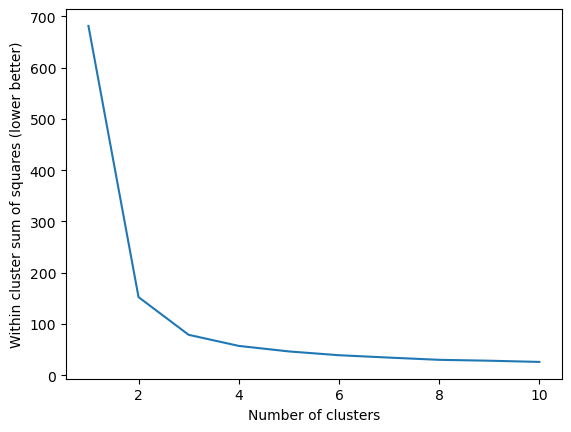

In [22]:
# An example of KMeans partitioning-clustering:
data = sklearn.datasets.load_iris()
true_clusters= data.target
cluster_names = data.target_names
x = data.data

# Let us see best fits for each K
wcss = []
for i in range(1, 11):
    kmeans = sklearn.cluster.KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('Within cluster sum of squares (lower better)') #within cluster sum of squares
plt.show()

#### Now we know that 3 clusters is enough
let us visualize these clusters with the help of dimensionality reduction; we use "Principal component analysis" to visualize the clusters

Of course, the clusters have no real meaning so we visualize them with the true classes

Accuracy of the unsupervised clustering: 89.3%


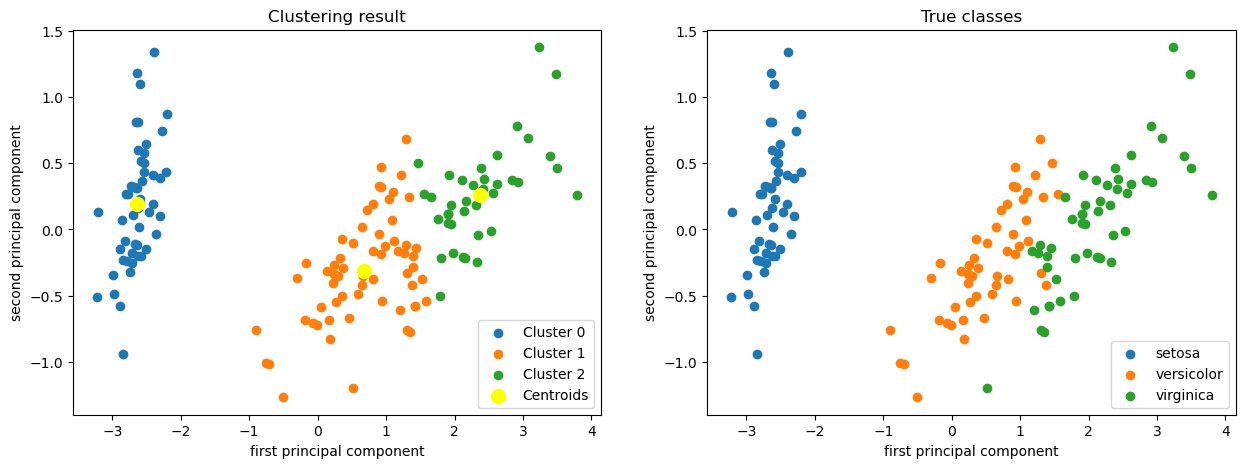

In [23]:
#Applying kmeans to the dataset / Creating the kmeans classifier
kmeans = sklearn.cluster.KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 3)
y_kmeans = kmeans.fit_predict(x)

PCA = sklearn.decomposition.PCA(n_components=2)

x_pca = PCA.fit_transform(x)

#Visualising the clusters
colors = sns.color_palette()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in np.unique(y_kmeans):
    plt.scatter(x_pca[y_kmeans == i, 0], x_pca[y_kmeans == i, 1], color=colors[i], label = "Cluster "+str(i))

centers_pca = PCA.transform(kmeans.cluster_centers_)
#Plotting the centroids of the clusters
plt.scatter(centers_pca[:, 0], centers_pca[:,1], s = 100, c = 'yellow', label = 'Centroids')
plt.xlabel("first principal component")
plt.ylabel("second principal component")
plt.title("Clustering result")

plt.legend()

plt.subplot(1,2,2)

for i in np.unique(y_kmeans):
    plt.scatter(x_pca[true_clusters == i, 0], x_pca[true_clusters == i, 1], color=colors[i], label = cluster_names[i])

plt.xlabel("first principal component")
plt.ylabel("second principal component")
plt.title("True classes")

plt.legend()

print("Accuracy of the unsupervised clustering: {0:.1f}%".format(np.mean(true_clusters==y_kmeans)*100))

Looks like k-means is not able to accurately distinguish between versicolor and virginica. But pretty good results nevertheless, 89.3% accuracy!